In [1]:
import os, re
import math

import numpy                   as np
import tables                  as tb
import matplotlib.pyplot       as plt

from   invisible_cities.io                import mcinfo_io
from   antea.io                           import mc_io

from   invisible_cities.core              import system_of_units as units
from   invisible_cities.evm.event_model   import Waveform
from   invisible_cities.io.mcinfo_io      import units_dict

from   typing                             import Mapping


In [2]:
COMPTON = 1
PHOTOELECTRIC = 0

In [3]:
dirname='/home/adriana/Petalo_dnn/data/'
files = os.listdir(dirname)
input_file= dirname + files[0]

In [4]:
def get_evt_energy(table):
    """Returns dictionary containing the energy of each event """
    
    energies_table   =  table.root.MC.events.read()
    keys             =  energies_table['evt_number']
    vals             =  energies_table['evt_energy']
    energy_dict      =  dict(zip(keys,vals))
    
    return  energy_dict



def get_pos_dict(table):
    """Returns dictionary of sensor_id: [x,y,z] """
    
    positions_table  =  table.root.MC.sensor_positions.read()
    keys             =  positions_table['sensor_id']
    vals             =  np.stack([positions_table['x'],positions_table['y'],positions_table['z']],axis=1)
    pos_dict         =  dict(zip(keys,vals))
    
    return pos_dict

In [5]:
def isphoto(event, event_energy):
    photoelectric = False
    
    if ((event_energy > 0.510) & (event_energy < 0.512)):
        for _, part in event.items():
            if part.name == 'e-' :
                mother = event[part.mother_indx]
                if part.initial_volume == 'ACTIVE' and part.final_volume == 'ACTIVE':
                    if np.isclose(sum(h.E for h in part.hits), 0.476443, atol=1.e-6):
                        if np.isclose(mother.E*1000., 510.999, atol=1.e-3) and mother.primary:
                            photoelectric = True
                        
    if photoelectric == True:
        return True
    else:
        return False
    
    
def iscompton(event, event_energy):
    
    compton = False
    if ((event_energy > 0.510) & (event_energy < 0.512)):
        for _, part in event.items():
            if part.name == 'e-' :
                mother = event[part.mother_indx]
                if part.initial_volume == 'ACTIVE' and part.final_volume == 'ACTIVE':
                    if np.isclose(mother.E*1000., 510.999, atol=1.e-3) and mother.primary:
                        if(part.process == 'compt'):
                            compton = True
    if compton == True:
        return True
    else:
        return False

In [6]:
def labeling(event, energy):
    if iscompton(event, energy) == True:
        return COMPTON
    elif isphoto(event, energy) == True:
        return PHOTOELECTRIC
    else:
        return "None"

In [7]:
def make_2d_image (waveforms, pos_dict, dimension_x=30, dimension_y=30, min_len=10):
    
    pos_and_char_of_sipm = []
    
    try:
        for sipm in waveforms.keys():
        #key error: algunos diccionarios estaban vacios.
            if (len(waveforms[sipm].charges) == 0): 
                print('------------ The list is empty -------------')
            else:
                pos_and_char_of_sipm.append(np.append(pos_dict[sipm], waveforms[sipm].charges))
                
    except IndexError:
        return pos_and_char_of_sipm
    
    
    pos_and_char_of_sipm = np.asarray(pos_and_char_of_sipm)
    
    # at least 10 simp are lighted. 
    if len(pos_and_char_of_sipm)>min_len:
    
        # transform from cartesian to cilindric coordinates.
        sipm_info=np.array(list(map(lambda sipm: [np.arctan2(sipm[1],sipm[0]),sipm[2],sipm[3]], pos_and_char_of_sipm))) 
            
            
        angle_sensors = sipm_info[:,0] # azimutal angle of the binning
        z_sensors     = sipm_info[:,1] # z position
        q_sensors     = sipm_info[:,2] # charges

        #function of mathplotlib making the 2d-histogram
        myimage, _, _, _ = plt.hist2d(angle_sensors, z_sensors, bins=[30,30], weights=q_sensors)
            
    return myimage

In [8]:
def get_images_with_labels(mcinfo, en_dict, waveforms, pos_dict):
    
    image_array = []
    label_array = []
    event_number_array = []
    
    for keys in mcinfo.keys():
        
        if labeling(mcinfo[keys], en_dict[keys]) is not "None":
            image = make_2d_image(waveforms[keys], pos_dict)
            label = labeling(mcinfo[keys], en_dict[keys])
            event_number   = np.array(keys)
            
            normalized_image = np.array(image/image.sum())
            
            label_array.append(label)
            image_array.append(normalized_image)
            event_number_array.append(event_number)
      
    label_array = np.array(label_array)
    image_array = np.array(image_array)
    image_array = np.reshape (image_array, (image_array.shape[0], image_array.shape[1], image_array.shape[2],1))
    event_number_array = np.array(event_number_array)
                                  
    return label_array, image_array, event_number_array

In [9]:
mytable = tb.open_file(input_file,mode='r')

In [10]:
print('---------------------read mytable-------------------------')
mcinfo     = mcinfo_io.read_mcinfo(mytable)
pos_dict   = get_pos_dict(mytable)
en_dict    =  get_evt_energy(mytable)

print('---------------------read waveforms-------------------------')
waveforms = mc_io.read_mcsns_response(input_file)

---------------------read mytable-------------------------
---------------------read waveforms-------------------------


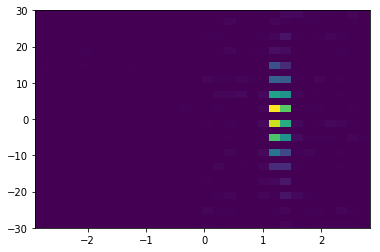

In [11]:
labels, images, events = get_images_with_labels(mcinfo, en_dict, waveforms, pos_dict)
training_set_test="training_set_test_should_be_right_072_accuracy.npz"
np.savez_compressed(training_set_test, labels=labels, images=images, event_number= events)